In [1]:
# !gdown --id '1yD6qZCQDzpuBnxX2FGaJxDvcDRU9OwIO' --output train.zip
# !gdown --id '1oP5_Sr1GVpkwrMWPfEBEet3EL7X-p5Ly' --output test.zip

#!wget -O train.zip "http://140.127.220.185/NN/ART/train.zip"
#!wget -O test.zip "http://140.127.220.185/NN/ART/test.zip"
#!unzip train.zip
#!unzip test.zip

import requests
import zipfile

In [2]:
#with zipfile.ZipFile("train.zip","r") as zip_ref:
    #zip_ref.extractall("train")

#url = 'C:/Users/Alex/Downloads/train.zip'
#r = requests.get(url, allow_redirects=True)
#open('train.zip', 'wb').write(r.content)

In [3]:
#url = 'C:\Users\Alex\Downloads\test.zip'
#r1 = requests.get(url, allow_redirects=True)
#open('test.zip', 'wb').write(r1.content)
#with zipfile.ZipFile("test.zip","r") as zip_ref:
    #zip_ref.extractall("test")

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random

In [5]:
train_dir = "./train/train_resized/"
test_dir = "./test/test_resized/"
artists = pd.read_csv(r'./train/artists.csv')
num_classes = artists.shape[0]
print("Number of artists : ",num_classes)
artists.head()

Number of artists :  50


,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: ?а?и?...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod m?n?]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [??ne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [6]:
artists = artists.loc[:,["name","paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

,name,paintings
0,Amedeo_Modigliani,193
1,Vasiliy_Kandinskiy,88
2,Diego_Rivera,70
3,Claude_Monet,73
4,Rene_Magritte,194


可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24


C:\Users\Alex\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


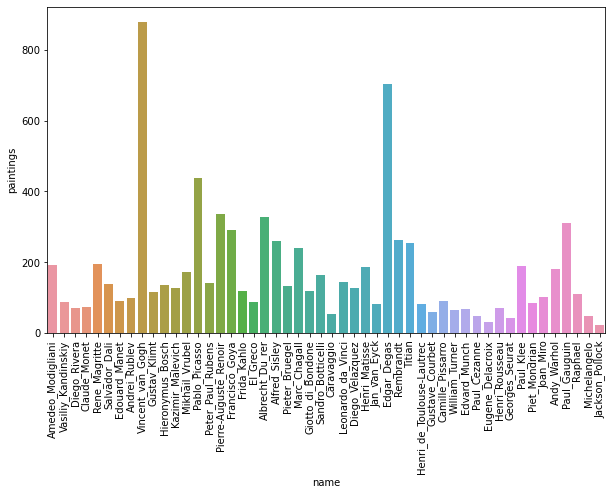

In [7]:
%matplotlib inline
plt.figure(figsize=(10, 6))
barplot = sns.barplot(artists.name,artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)
    
print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ",artists.paintings.max()," 最少畫作為 : ",artists.paintings.min())

training 畫作總共畫作有 :  30080


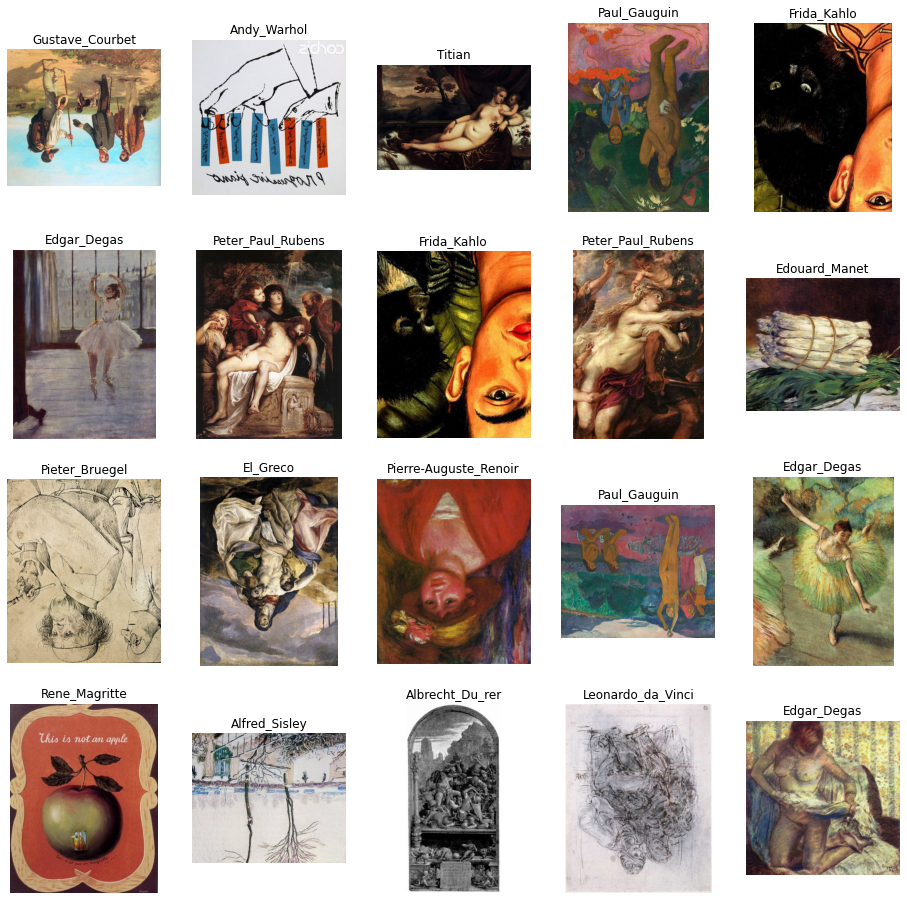

In [8]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
randomlist = random.sample(range(0,total_len), 20)
print("training 畫作總共畫作有 : ",total_len)

show_imgs = [img_list[rand] for rand in randomlist]

plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
    imgpath = train_dir+imgName
    img = cv.imread(imgpath)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.subplot(4,5,index+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

In [9]:
# 請建立將英文映射成數字的dict。EX: Van_Gogh --> 0
def make_Authordict():
    dict={}
    for i in range(50):
        dict[artists["name"][i]] = i
    return dict

class_name = make_Authordict()

# 請建立將數字映射成英文的dict。 EX: 0 --> Van_Gogh
def make_revAuthordict():
    dict={}
    for i in range(50):
        dict[i] = artists["name"][i]
    return dict
rev_class_name = make_revAuthordict()
print(class_name['Amedeo_Modigliani'])
print(rev_class_name[0])

0
Amedeo_Modigliani


In [10]:
def get_label(picName):
  # 請取出label並轉成數字
  # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
  ##########
  # todo #
  ##########
  return class_name["_".join(picName.split("_")[:-1])]

def get_path(dir,picName):
  # 請將路徑合併
  # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg
  ##########
  # todo #
  ##########
  return dir+picName

def make_paths_label(dir):
    img_list = os.listdir(dir)
    paths = []
    labels = []
  
  # 將preprocess完成的path、label用for迴圈放入paths和labels
  ##########
  # todo #
    for i in img_list:
        paths.append(get_path(dir,i))
        labels.append(get_label(i))
  ##########
  
  # 將labels轉成onehot
  # todo
    onehot_labels = keras.utils.to_categorical(labels, 50)
    return paths,onehot_labels

In [11]:
# 來查看一下
paths,onehot_labels = make_paths_label(train_dir)

print("paths : ")
for p in paths[:5]:
    print(p)
print("-"*20)
print("labels : ")
for label in onehot_labels[:5]:
    print(label)

paths : 
./train/train_resized/Albrecht_Du_rer_10.jpg
./train/train_resized/Albrecht_Du_rer_100.jpg
./train/train_resized/Albrecht_Du_rer_101.jpg
./train/train_resized/Albrecht_Du_rer_102.jpg
./train/train_resized/Albrecht_Du_rer_103.jpg
--------------------
labels : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [12]:
# 轉成tensorflow dataset格式，變成路徑tensor
# 這個只是from_tensor_slices範例
paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
    print(tensor)

turn to tensor
tf.Tensor(b'./train/train_resized/Albrecht_Du_rer_10.jpg', shape=(), dtype=string)
tf.Tensor(b'./train/train_resized/Albrecht_Du_rer_100.jpg', shape=(), dtype=string)
tf.Tensor(b'./train/train_resized/Albrecht_Du_rer_101.jpg', shape=(), dtype=string)
tf.Tensor(b'./train/train_resized/Albrecht_Du_rer_102.jpg', shape=(), dtype=string)
tf.Tensor(b'./train/train_resized/Albrecht_Du_rer_103.jpg', shape=(), dtype=string)


In [13]:

# 決定你輸入模型的圖片長寬
# shuffle buffle size
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_SIZE = (IMG_WIDTH,IMG_HEIGHT)
shuffle_buffer = 30080

count1=8000

aa=[]
for i in paths:
    newii=i.split('/')[-1]
    newi='/'.join(i.split('/')[0:-1])+'/'+'_'.join(i.split('/')[-1].split('_')[0:-1])+'_'+str(count1)+'.'+newii.split('.')[-1]
    aa.append(newi)
    img1=cv.imread(i)    
    img2 = cv.cvtColor(img1,cv.COLOR_BGR2RGB)
    img2 = cv.flip(img2, 0)
    img2 = cv.cvtColor(img2,cv.COLOR_RGB2BGR)
    cv.imwrite(newi,img2)
    count1 = count1+1

    newii=i.split('/')[-1]
    newi='/'.join(i.split('/')[0:-1])+'/'+'_'.join(i.split('/')[-1].split('_')[0:-1])+'_'+str(count1)+'.'+newii.split('.')[-1]

    img3 = cv.cvtColor(img1,cv.COLOR_BGR2RGB)
    img3 = cv.flip(img3, 1)
    img3 = cv.cvtColor(img3,cv.COLOR_RGB2BGR)
    cv.imwrite(newi,img3)
    count1 = count1+1

    newii=i.split('/')[-1]
    newi='/'.join(i.split('/')[0:-1])+'/'+'_'.join(i.split('/')[-1].split('_')[0:-1])+'_'+str(count1)+'.'+newii.split('.')[-1]

    img4 = cv.cvtColor(img1,cv.COLOR_BGR2RGB)
    img4 = cv.flip(img4, -1)
    img4 = cv.cvtColor(img4,cv.COLOR_RGB2BGR)
    cv.imwrite(newi,img4)
    count1 = count1+1


def get_image(path):
  # read image from path
    file = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file,channels=3)
    img = tf.cast(img,tf.float32)


  # 請固定每張圖片大小為IMG_HEIGHT、IMG_WIDTH
  # 並將圖片每個pixel映射到[0,1]之間
  ##########
  # todo #
  ##########
    img = tf.image.resize(img,IMG_SIZE)
    img = img/255
    return img


# 將所有資料轉成Tensor -> Tensor 轉成圖片
# 圖片Tensor 與 label Tensor Zip起來成一個pair
# shuffle打散
def make_dataset(dir):
    paths,onehot_labels = make_paths_label(dir)
    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

  # 將路徑tensor映射成圖片tensor 
    train_image = paths_ds.map(get_image)
    
  # 合併圖片與label資料集
    full_ds = tf.data.Dataset.zip((train_image,train_label))
  # 打散

    full_ds = full_ds.shuffle(shuffle_buffer,reshuffle_each_iteration=False)
    return full_ds

full_ds = make_dataset(train_dir)

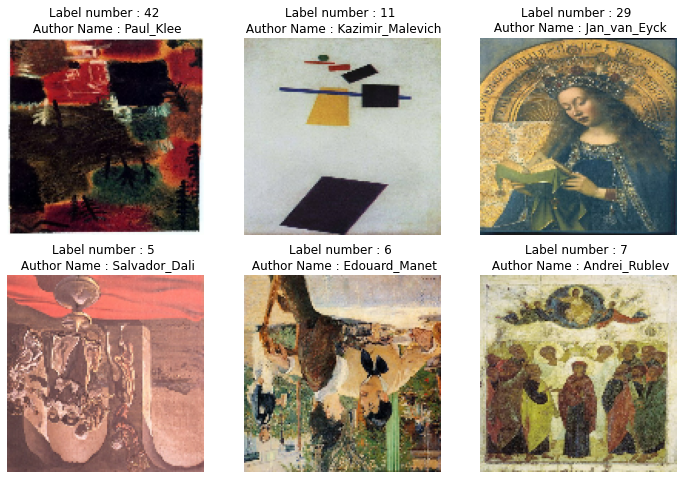

In [14]:
# 取出Tensor圖片來看看
plt.figure(figsize=(12, 8))
for index,(img,label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2,3,index+1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(
        l,
        rev_class_name[l]))
    plt.axis("off")

In [15]:
# 切割成training data與validation data
train_len = int(0.8*total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ",train_len," val size : ",val_len)

# 添加batch
# todo
batch_size = 64

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train size :  24064  val size :  6016


In [16]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x,y = trainiter.next()
print("training image batch shape : ",x.shape)
print("training label batch shape : ",y.shape)

training image batch shape :  (64, 128, 128, 3)
training label batch shape :  (64, 50)


In [17]:
input_shape = (IMG_WIDTH,IMG_HEIGHT,3)

# 自訂你的model
##########
# todo #
##########
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same",data_format="channels_last"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same",data_format="channels_last"),
        layers.MaxPooling2D(pool_size=(4, 4)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same",data_format="channels_last"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same",data_format="channels_last"),
        layers.MaxPooling2D(pool_size=(4, 4)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same",data_format="channels_last"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same",data_format="channels_last"),
        layers.MaxPooling2D(pool_size=(4, 4)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(1024, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [18]:
# todo
epochs = 20

##########
# todo #
##########
# model.compile 決定learning strategy、Loss caculator

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
376/376 [==============================] - 270s 402ms/step - loss: 3.5969 - accuracy: 0.1110 - val_loss: 2.9567 - val_accuracy: 0.2384
Epoch 2/20
376/376 [==============================] - 263s 396ms/step - loss: 2.9236 - accuracy: 0.2319 - val_loss: 2.6673 - val_accuracy: 0.3017
Epoch 3/20
376/376 [==============================] - 269s 405ms/step - loss: 2.6757 - accuracy: 0.2874 - val_loss: 2.4615 - val_accuracy: 0.3399
Epoch 4/20
376/376 [==============================] - 292s 437ms/step - loss: 2.4836 - accuracy: 0.3283 - val_loss: 2.2667 - val_accuracy: 0.3823
Epoch 5/20
376/376 [==============================] - 294s 458ms/step - loss: 2.3125 - accuracy: 0.3624 - val_loss: 2.1566 - val_accuracy: 0.4074
Epoch 6/20
376/376 [==============================] - 296s 443ms/step - loss: 2.1620 - accuracy: 0.4018 - val_loss: 1.9883 - val_accuracy: 0.4478
Epoch 7/20
376/376 [==============================] - 299s 455ms/step - loss: 2.0483 - accuracy: 0.4242 - val_loss: 1.8908 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


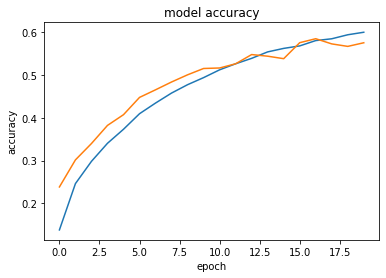

In [19]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

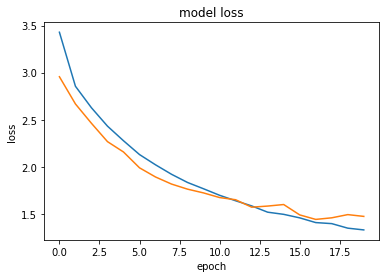

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [21]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(batch_size)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

14/14 [==============================] - 6s 46ms/step - loss: 2.0432 - accuracy: 0.4659
Test loss: 2.043217420578003
Test accuracy: 0.4658682644367218


In [22]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [23]:
def preditAuthor(img):
    img = img.reshape((1,IMG_HEIGHT,IMG_WIDTH,3))
    result = model.predict(img)
    result = np.argmax(result)
    authorName = rev_class_name[result]
    return authorName



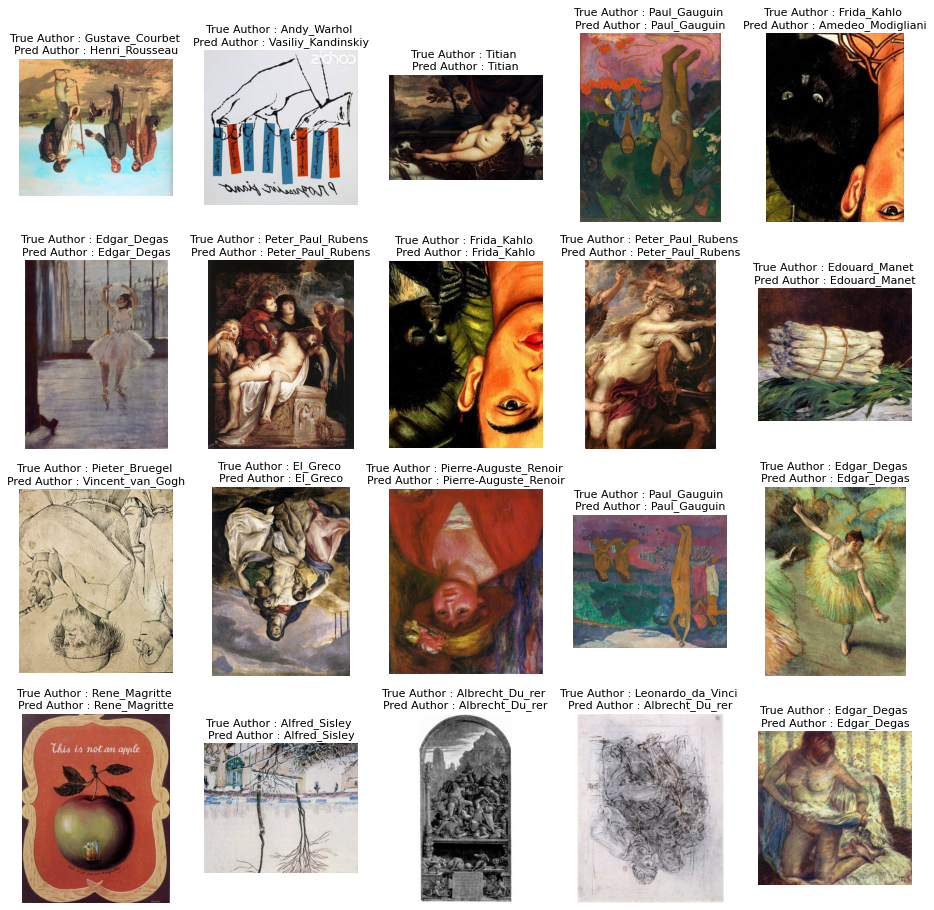

In [24]:
plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
    imgpath = train_dir+imgName
    img = cv.imread(imgpath)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.subplot(4,5,index+1)
    plt.axis("off")
    plt.imshow(img)
    img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = img / 255.0
    plt.title("True Author : {} \nPred Author : {}".format("_".join(imgName.split("_")[:-1]),preditAuthor(img)),size=11)

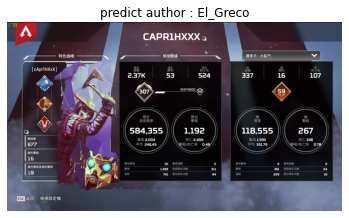

In [25]:
import io
from IPython.display import display
import fileupload

def upload_img():
    img = cv.imread('cApr1HXxX.png')
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.imshow(img)
    img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = img/255.0
    return img
def eval():
    img = upload_img()
    plt.title("predict author : {}".format(preditAuthor(img)))
    plt.axis("off")
    plt.show()
# 自己上傳一張圖片來試試看
# Demo圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()